<html><head><meta content="text/html; charset=UTF-8" http-equiv="content-type"><style type="text/css">ol</style></head><body class="c5"><p class="c0 c4"><span class="c3"></span></p><p class="c2 title" id="h.rrbabt268i6e"><h1>CaImAn&rsquo;s Demo pipeline</h1></p><p class="c0"><span class="c3">This notebook will help to demonstrate the process of CaImAn and how it uses different functions to denoise, deconvolve and demix neurons from a Calcium Imaging Video. </span></p>
<p><img src="../../docs/img/quickintro.png" /></p>
<p class="c0"><span class="c3">More information can be found in CaImAn&rsquo;s documentation. </span></p>
</html>



In [1]:
#!/usr/bin/env python
from __future__ import division
from __future__ import print_function

try:
    get_ipython().magic(u'load_ext autoreload')
    get_ipython().magic(u'autoreload 2')    
except:
    print('Not IPYTHON')

get_ipython().magic(u'matplotlib qt')
import numpy as np
import matplotlib.pyplot as plt
import caiman as cm
from caiman.source_extraction import cnmf
from caiman.utils.utils import download_demo
from caiman.utils.visualization import inspect_correlation_pnr
from caiman.components_evaluation import estimate_components_quality_auto
from caiman.motion_correction import motion_correct_oneP_rigid, motion_correct_oneP_nonrigid
from caiman.utils.visualization import plot_contours, nb_view_patches, nb_plot_contour
import cv2

try:
    cv2.setNumThreads(0)
except:
    pass
import bokeh.plotting as bpl
bpl.output_notebook()

The above is a dangerous import that can create circular dependencies


Loading BokehJS ...

### Setup some parameters
few of them (that typically shouldn't be changed for 1p data) will be set directly calling the CNMF object

In [2]:
# dataset dependent parameters
# fnames = ['data_endoscope.tif']  # filename to be processed
frate = 10                       # movie frame rate
decay_time = 0.1                 # length of a typical transient in seconds

In [3]:
# motion correction parameters
do_motion_correction_nonrigid = False
do_motion_correction_rigid = not  do_motion_correction_nonrigid # in this case it will also save a rigid motion corrected movie
gSig_filt = (4, 4)       # size of filter, in general gSig (see below),
#                          change this one if algorithm does not work
max_shifts = (5, 5)      # maximum allowed rigid shift
splits_rig = 10          # for parallelization split the movies in  num_splits chuncks across time
strides = (48, 48)       # start a new patch for pw-rigid motion correction every x pixels
overlaps = (24, 24)      # overlap between pathes (size of patch strides+overlaps)
splits_els = 10          # for parallelization split the movies in  num_splits chuncks across time
#                          (remember that it should hold that length_movie/num_splits_to_process_rig>100)
upsample_factor_grid = 4 # upsample factor to avoid smearing when merging patches
max_deviation_rigid = 3  # maximum deviation allowed for patch with respect to rigid shifts

Download the dataset if not already present

In [4]:
fnames = ['/home/sebastian/Desktop/32364_20170710_cropped.tif']#[download_demo(fnames[0])]

### (Re)start cluster.  

In [5]:
import psutil

# stop the cluster if one exists
n_processes = psutil.cpu_count()
print('using ' + str(n_processes) + ' processes')
print("Stopping  cluster to avoid unnencessary use of memory....")

using 16 processes
Stopping  cluster to avoid unnencessary use of memory....


In [6]:
try:
    cm.stop_server(dview=dview) # stop it if it was running
except:
    pass

c, dview, n_processes = cm.cluster.setup_cluster(backend='local', # use this one
                                                 n_processes=n_processes,  # number of process to use, if you go out of memory try to reduce this one
                                                 )

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
0
0
0
0
0
0
0
0
10
340
10
10
10
0
10
10
20
10
10
20
20
350
20
20
10
20
30
20
20
30
30
30
360
30
30
40
20
30
40
30
40
40
30
370
40
40
40
40
50
50
40
50
380
50
50
60
50
50
50
50
60
60
60
60
390
60
70
60
60
60
70
70
70
70
400
70
80
70
70
70
80
80
80
80
90
90
410
80
80
100
90
90
90
80
100
80
110
420
100
90
110
100
100
90
110
120
90
130
430
90
100
120
110
120
110
140
130
100
100
110
140
100
440
130
120
120
150
150
120
110
110
450
110
140
160
160
130
130
120
130
460
150
120
120
170
160
140
170
170
140
140
470
180
130
180
150
130
130
180
190
160
190
150
150
190
480
140
200
200
140
140
200
170
210
160
220
490
210
150
160
210
150
150
220
180
220
230
170
230
500
240
160
170
230
160
160
190
240
180
510
250
170
240
200
180
170
250
170
260
190
520
250
210
260
270
190
180
260
180
180
200
530
220
280
270
200
270
190
190
210
280
190
230
540
290
210
280
200
200
200
220
290
240
55

2250
1690
2160
1670
1580
2170
2180
2060
1640
1700
2180
2260
2190
2190
1700
1680
1680
2200
1590
1710
2070
1650
2270
2200
2210
2210
1710
1690
1600
1690
2220
1660
2220
1720
2230
2080
2280
1720
2230
1610
2240
1700
2240
1700
1670
2250
1730
2250
2090
1730
2290
2260
2260
1710
1620
2270
1710
2270
1680
2280
1740
2100
1740
2300
2280
2290
2110
1630
1720
1690
2310
1750
1720
1730
2300
1750
2290
1740
2320
2120
1750
1640
1700
1760
1730
1760
2300
2310
1760
2130
2330
1770
1740
1650
1710
1770
2310
2320
2340
1770
2140
1660
1750
1780
1720
1790
1780
1670
2320
2330
2150
2350
1800
1780
1760
2160
1730
1680
1810
1790
2330
2340
1770
2360
2350
2170
1790
1690
1740
1820
2340
1800
1800
2360
1700
1780
2180
2370
2350
1810
1750
1830
1810
1710
1840
2370
2360
2380
2190
1820
1790
1760
1820
1800
1850
1720
2200
2380
1830
1860
2370
2390
1810
1770
1830
1730
2210
1870
2400
2390
1840
1820
2380
1740
1840
1780
2220
1880
1890
2400
2410
1830
2230
1850
1900
2390
1850
1910
1750
1840
1790
1860
1860
2240
2410
2400
1920
2420
1850
1760


/home/sebastian/Documents/CaImAn/caiman/motion_correction.py:2457: RuntimeWarning: Mean of empty slice
  new_temp = np.nanmean(mc, 0)


2780
2710
2790
2790
2720
2730
2740
2750
2760
2770
2780
2790


/home/sebastian/Documents/CaImAn/caiman/motion_correction.py:2457: RuntimeWarning: Mean of empty slice
  new_temp = np.nanmean(mc, 0)
/home/sebastian/Documents/CaImAn/caiman/motion_correction.py:2457: RuntimeWarning: Mean of empty slice
  new_temp = np.nanmean(mc, 0)


(28000, 101, 101)
using 1 processes
using 2500 pixels per process
using 5000 block_size
preprocessing ...
checking if missing data
(28000, 101, 101)
using 1 processes
using 2500 pixels per process
using 5000 block_size
preprocessing ...
checking if missing data
(28000, 101, 100)
using 1 processes
using 2500 pixels per process
(28000, 101, 101)
using 5000 block_size
using 1 processes
using 2500 pixels per process
preprocessing ...
using 5000 block_size
checking if missing data
preprocessing ...
checking if missing data
(28000, 101, 101)
using 1 processes
using 2500 pixels per process
using 5000 block_size
preprocessing ...
initializing ...
checking if missing data
(28000, 101, 101)
using 1 processes
using 2500 pixels per process
using 5000 block_size
preprocessing ...
checking if missing data
(28000, 101, 101)
using 1 processes
using 2500 pixels per process
using 5000 block_size
preprocessing ...
checking if missing data
(28000, 101, 101)
(28000, 101, 101)
using 1 processes
using 2500 p

/home/sebastian/anaconda3/envs/caiman/lib/python3.6/site-packages/scipy/sparse/compressed.py:746: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


memmaping
Updating Spatial Components using lasso lars
Update Spatial
Initializing update of Spatial Components
computing the distance indicators


/home/sebastian/anaconda3/envs/caiman/lib/python3.6/site-packages/scipy/sparse/compressed.py:746: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


memmaping
Updating Spatial Components using lasso lars
Compute Background
Update Spatial
Initializing update of Spatial Components
computing the distance indicators


/home/sebastian/anaconda3/envs/caiman/lib/python3.6/site-packages/scipy/sparse/compressed.py:746: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


Update Spatial
Initializing update of Spatial Components
computing the distance indicators


/home/sebastian/anaconda3/envs/caiman/lib/python3.6/site-packages/scipy/sparse/compressed.py:746: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


Update Spatial
Initializing update of Spatial Components
computing the distance indicators


/home/sebastian/anaconda3/envs/caiman/lib/python3.6/site-packages/scipy/sparse/compressed.py:746: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


memmaping
Updating Spatial Components using lasso lars
memmaping
Updating Spatial Components using lasso lars
Update Spatial
Initializing update of Spatial Components
computing the distance indicators


/home/sebastian/anaconda3/envs/caiman/lib/python3.6/site-packages/scipy/sparse/compressed.py:746: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


memmaping
Updating Spatial Components using lasso lars
memmaping
Updating Spatial Components using lasso lars
thresholding components
Computing residuals
--- 22.708887577056885 seconds ---
Removing tempfiles created
Update Temporal
Generating residuals
thresholding components
Computing residuals
--- 18.29021143913269 seconds ---
Removing tempfiles created
Update Temporal
Generating residuals
thresholding components
entering the deconvolution 
1 out of total 2 temporal components updated
Computing residuals
--- 26.14220380783081 seconds ---
Removing tempfiles created
Update Temporal
Generating residuals
2 out of total 2 temporal components updated
1 out of total 2 temporal components updated
entering the deconvolution 
2 out of total 2 temporal components updated
stopping: overall temporal component not changing significantly
Initialization again
thresholding components
Computing residuals
--- 14.922220706939697 seconds ---
Removing tempfiles created
Update Temporal
Generating residuals

/home/sebastian/anaconda3/envs/caiman/lib/python3.6/site-packages/scipy/sparse/compressed.py:746: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


entering the deconvolution 
3 out of total 5 temporal components updated
5 out of total 5 temporal components updated
3 out of total 5 temporal components updated
5 out of total 5 temporal components updated
stopping: overall temporal component not changing significantly
Initialization again
memmaping
Updating Spatial Components using lasso lars
thresholding components
Computing residuals
--- 17.825811624526978 seconds ---
Removing tempfiles created
Update Temporal
Generating residuals
Update Spatial
Initializing update of Spatial Components
computing the distance indicators


/home/sebastian/anaconda3/envs/caiman/lib/python3.6/site-packages/scipy/sparse/compressed.py:746: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


0 neurons have been initialized
memmaping
Updating Spatial Components using lasso lars
entering the deconvolution 
9 out of total 25 temporal components updated
16 out of total 25 temporal components updated
20 out of total 25 temporal components updated
22 out of total 25 temporal components updated
23 out of total 25 temporal components updated
24 out of total 25 temporal components updated
25 out of total 25 temporal components updated
9 out of total 25 temporal components updated
16 out of total 25 temporal components updated
20 out of total 25 temporal components updated
22 out of total 25 temporal components updated
23 out of total 25 temporal components updated
24 out of total 25 temporal components updated
25 out of total 25 temporal components updated
stopping: overall temporal component not changing significantly
Initialization again
0 neurons have been initialized
Update Spatial
Initializing update of Spatial Components
computing the distance indicators


/home/sebastian/anaconda3/envs/caiman/lib/python3.6/site-packages/scipy/sparse/compressed.py:746: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


Update Spatial
Initializing update of Spatial Components
computing the distance indicators
memmaping
Updating Spatial Components using lasso lars
thresholding components
Computing residuals
--- 14.104506969451904 seconds ---
Removing tempfiles created
Update Temporal
Generating residuals
Update Spatial
Initializing update of Spatial Components
computing the distance indicators
In total,  39 neurons were initialized.
memmaping
Updating Spatial Components using lasso lars
0 neurons have been initialized
memmaping
Updating Spatial Components using lasso lars
0 neurons have been initialized
entering the deconvolution 
5 out of total 13 temporal components updated
8 out of total 13 temporal components updated
10 out of total 13 temporal components updated
0 neurons have been initialized
12 out of total 13 temporal components updated
13 out of total 13 temporal components updated
thresholding components
Computing residuals
Update Spatial
Initializing update of Spatial Components
computing th

/home/sebastian/anaconda3/envs/caiman/lib/python3.6/site-packages/scipy/sparse/compressed.py:746: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


5 out of total 13 temporal components updated
--- 7.347333192825317 seconds ---
Removing tempfiles created
Update Temporal
Generating residuals
8 out of total 13 temporal components updated
10 out of total 13 temporal components updated
12 out of total 13 temporal components updated
13 out of total 13 temporal components updated
stopping: overall temporal component not changing significantly
Initialization again
Compute Background
memmaping
Updating Spatial Components using lasso lars
thresholding components
Computing residuals
--- 9.280366659164429 seconds ---
Removing tempfiles created
Update Temporal
Generating residuals
thresholding components
In total,  3 neurons were initialized.
Computing residuals
--- 12.14362645149231 seconds ---
Removing tempfiles created
Update Temporal
Merge Components
Generating residuals
[0 1 2 4]
Update Spatial
Initializing update of Spatial Components
computing the distance indicators


/home/sebastian/anaconda3/envs/caiman/lib/python3.6/site-packages/scipy/sparse/dia.py:300: RuntimeWarning: divide by zero encountered in remainder
  c = np.arange(num_rows, dtype=np.intc) - (offsets % max_dim)[:, None]


entering the deconvolution 
stopping: overall temporal component not changing significantly
Initialization again
0 neurons have been initialized


/home/sebastian/anaconda3/envs/caiman/lib/python3.6/site-packages/scipy/sparse/dia.py:300: RuntimeWarning: divide by zero encountered in remainder
  c = np.arange(num_rows, dtype=np.intc) - (offsets % max_dim)[:, None]


entering the deconvolution 
stopping: overall temporal component not changing significantly
Initialization again
memmaping
Updating Spatial Components using lasso lars
entering the deconvolution 
6 out of total 15 temporal components updated
10 out of total 15 temporal components updated
12 out of total 15 temporal components updated
In total,  5 neurons were initialized.
14 out of total 15 temporal components updated
15 out of total 15 temporal components updated
Merge Components
[0 3 4 5 7 8]
Update Spatial
Initializing update of Spatial Components
computing the distance indicators
6 out of total 15 temporal components updated
10 out of total 15 temporal components updated
12 out of total 15 temporal components updated
14 out of total 15 temporal components updated
15 out of total 15 temporal components updated
stopping: overall temporal component not changing significantly
Initialization again
memmaping
Updating Spatial Components using lasso lars
thresholding components
Computing r

/home/sebastian/anaconda3/envs/caiman/lib/python3.6/site-packages/scipy/sparse/compressed.py:746: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


memmaping
Updating Spatial Components using lasso lars
memmaping
Updating Spatial Components using lasso lars
thresholding components
Computing residuals
--- 17.778857469558716 seconds ---
Removing tempfiles created
Update Temporal
Generating residuals
entering the deconvolution 
6 out of total 9 temporal components updated
8 out of total 9 temporal components updated
9 out of total 9 temporal components updated
6 out of total 9 temporal components updated
8 out of total 9 temporal components updated
9 out of total 9 temporal components updated
stopping: overall temporal component not changing significantly
Compute Background Again
Update Spatial
Initializing update of Spatial Components
computing the distance indicators


/home/sebastian/anaconda3/envs/caiman/lib/python3.6/site-packages/scipy/sparse/compressed.py:746: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


In total,  91 neurons were initialized.
memmaping
Updating Spatial Components using lasso lars
In total,  48 neurons were initialized.
Merge Components
thresholding components
[ 2  6  8 16 19 31 34 40 42 44 47 52]
[ 0  4  5 12 13 14 15 18 20 21 22 24 25 29 30 32 37 38 45 46 48 54 57 59 60
 61 62 64 65 66]
Compute Background
Computing residuals
[11 23 26 50 56]
--- 65.51491689682007 seconds ---
Removing tempfiles created
Update Temporal
Generating residuals
[ 3  9 27 39 53 58]
[33 35 51 63]
[10 28 49 55]
[ 1 36]
[ 7 17]
Update Spatial
Initializing update of Spatial Components
computing the distance indicators
memmaping
Updating Spatial Components using lasso lars
Merge Components
No neurons merged!
Update Spatial
Initializing update of Spatial Components
computing the distance indicators
memmaping
Updating Spatial Components using lasso lars
entering the deconvolution 
15 out of total 39 temporal components updated
24 out of total 39 temporal components updated
30 out of total 39 tempor

/home/sebastian/anaconda3/envs/caiman/lib/python3.6/site-packages/scipy/sparse/compressed.py:746: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


In total,  37 neurons were initialized.
memmaping
Updating Spatial Components using lasso lars
74 out of total 74 temporal components updated
stopping: overall temporal component not changing significantly
Initialization again
Merge Components
[ 0  2  4 14 16 17 18 22 23 24 28 29 38 54 57]
[ 5 19 21 25 33 36 37 40 51 52 56 59]
[ 1 12 13 15 26 27 30 31 53 61]
[ 8 11 32 34 35 55 58 60]
[ 7 10 43 44]
[ 3  6 39]
[46 49 50]
Update Spatial
Initializing update of Spatial Components
computing the distance indicators
memmaping
Updating Spatial Components using lasso lars
memmaping
Updating Spatial Components using lasso lars
thresholding components
Computing residuals
--- 42.6735942363739 seconds ---
Removing tempfiles created
Update Temporal
Generating residuals
Merge Components
No neurons merged!
Update Spatial
Initializing update of Spatial Components
computing the distance indicators
entering the deconvolution 
In total,  31 neurons were initialized.
Merge Components
memmaping
[ 0  1  8  9 

/home/sebastian/anaconda3/envs/caiman/lib/python3.6/site-packages/scipy/sparse/compressed.py:746: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


70 out of total 91 temporal components updated
80 out of total 91 temporal components updated
Merge Components
No neurons merged!
Update Spatial
Initializing update of Spatial Components
computing the distance indicators
5 out of total 10 temporal components updated
87 out of total 91 temporal components updated
89 out of total 91 temporal components updated
In total,  57 neurons were initialized.
91 out of total 91 temporal components updated
Merge Components
[ 0  5 15 16 21 25 26 35 36 40 42 46 49 50 59 66 75 85 92]
[11 13 14 31 32 33 34 38 48 69 80 82 84 86 94]
[ 1  6  9 18 27 29 37 41 44 47 53 55 68 89]
[ 4  7 20 23 56 70 74 83 90 93]
memmaping
Updating Spatial Components using lasso lars
[ 2  3 12 19 30 52 63 88]
[10 17 77]
[ 8 64]
[51 87]
21 out of total 91 temporal components updated
[24 73]
Update Spatial
Initializing update of Spatial Components
computing the distance indicators
memmaping
Updating Spatial Components using lasso lars
40 out of total 91 temporal components updat

In total,  73 neurons were initialized.
0 neurons have been initialized
Merge Components
[  1   2   4   6  12  15  20  23  26  28  30  34  35  37  39  41  45  47
  49  55  56  58  60  62  66  80  96  97 101 106]
[  0  10  13  14  25  27  36  38  40  42  43  44  46  53  68  74  92  95
  98 105 107 109]
12 out of total 12 temporal components updated
[ 9 22 29 50 51 61 78 94 99]
[  3   8  11  16  17  18  19  21  24  31  32  52  54  57  63  64  65  76
  77  83  88  93 100]
thresholding components
[102 110]
Computing residuals
--- 27.002598524093628 seconds ---
Removing tempfiles created
Update Temporal
Generating residuals
[48 71]
Update Spatial
Initializing update of Spatial Components
computing the distance indicators
11 out of total 11 temporal components updated
stopping: overall temporal component not changing significantly
Return full Background
entering the deconvolution 
5 out of total 5 temporal components updated
5 out of total 5 temporal components updated
stopping: overall temp

Compute Background Again
Update Spatial
Initializing update of Spatial Components
computing the distance indicators
In total,  96 neurons were initialized.
memmaping
Updating Spatial Components using lasso lars
In total,  47 neurons were initialized.
Compute Background
0 neurons have been initialized
thresholding components
Computing residuals
--- 43.31733298301697 seconds ---
Removing tempfiles created
Update Temporal
Generating residuals
thresholding components
Computing residuals
--- 17.474743604660034 seconds ---
Removing tempfiles created
Update Temporal
Generating residuals
Compute Background
0 neurons have been initialized
entering the deconvolution 
18 out of total 25 temporal components updated
12 out of total 35 temporal components updated
entering the deconvolution 
3 out of total 3 temporal components updated
21 out of total 35 temporal components updated
3 out of total 3 temporal components updated
stopping: overall temporal component not changing significantly
Initializat

/home/sebastian/anaconda3/envs/caiman/lib/python3.6/site-packages/scipy/sparse/compressed.py:746: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


memmaping
Updating Spatial Components using lasso lars
thresholding components
Computing residuals
--- 115.78342914581299 seconds ---
Removing tempfiles created
Update Temporal
Generating residuals
Update Spatial
Initializing update of Spatial Components
computing the distance indicators
entering the deconvolution 
Merge Components
[14 26 32]
[ 9 10]
[ 1 16]
[17 29]
[20 39]
memmaping
Updating Spatial Components using lasso lars
[2 5]
Update Spatial
Initializing update of Spatial Components
computing the distance indicators
Update Spatial
Initializing update of Spatial Components
computing the distance indicators
memmaping
Updating Spatial Components using lasso lars
memmaping
Updating Spatial Components using lasso lars
0 neurons have been initialized
0 neurons have been initialized
thresholding components
Computing residuals
--- 39.24323868751526 seconds ---
Removing tempfiles created
Update Temporal
Generating residuals
100 neurons have been initialized
thresholding components
Comput

memmaping
Updating Spatial Components using lasso lars
entering the deconvolution 
100 neurons have been initialized
Update Spatial
Initializing update of Spatial Components
computing the distance indicators
thresholding components
eliminating 1 empty spatial components
Computing residuals
--- 50.72752022743225 seconds ---
Removing tempfiles created
Update Temporal
Generating residuals
entering the deconvolution 
7 out of total 10 temporal components updated
10 out of total 10 temporal components updated
In total,  102 neurons were initialized.
7 out of total 10 temporal components updated
10 out of total 10 temporal components updated
stopping: overall temporal component not changing significantly
Compute Background Again
memmaping
Updating Spatial Components using lasso lars
thresholding components
Computing residuals
--- 28.220094203948975 seconds ---
Removing tempfiles created
Update Temporal
Generating residuals
entering the deconvolution 
5 out of total 5 temporal components upda

/home/sebastian/anaconda3/envs/caiman/lib/python3.6/site-packages/scipy/sparse/compressed.py:746: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


10 out of total 18 temporal components updated
Merge Components
[ 0 17]
[ 9 11]
[15 22 23]
[3 6]
memmaping
Updating Spatial Components using lasso lars
Update Spatial
Initializing update of Spatial Components
computing the distance indicators
memmaping
Updating Spatial Components using lasso lars
True
100 neurons have been initialized
In total,  68 neurons were initialized.
Update Spatial
Initializing update of Spatial Components
computing the distance indicators
Merge Components
No neurons merged!
Update Spatial
Initializing update of Spatial Components
computing the distance indicators
memmaping
Updating Spatial Components using lasso lars
Compute Background
memmaping
Updating Spatial Components using lasso lars
Merge Components
No neurons merged!
Update Spatial
Initializing update of Spatial Components
computing the distance indicators
memmaping
Updating Spatial Components using lasso lars
31 out of total 33 temporal components updated
32 out of total 33 temporal components updated


Compute Background Again
26 out of total 33 temporal components updated
0 neurons have been initialized
thresholding components
Computing residuals
--- 113.17981934547424 seconds ---
10 out of total 10 temporal components updated
Removing tempfiles created
Update Temporal
Generating residuals
entering the deconvolution 
30 out of total 33 temporal components updated
6 out of total 10 temporal components updated
Merge Components
[10 11]
[5 8]
Update Spatial
Initializing update of Spatial Components
computing the distance indicators
In total,  76 neurons were initialized.
Merge Components
memmaping
Updating Spatial Components using lasso lars
0 neurons have been initialized
[  0   1   5  10  12  14  15  16  20  23  26  27  28  29  30  32  34  36
  37  39  40  42  45  47  50  51  54  56  57  60  67  72  73  75  76  78
  81  86  87  88  89  93  94  97  98  99 104 107 108]
[  2   3   4   7   8   9  11  13  17  24  25  31  33  35  38  43  46  48
  49  53  59  91  92  95  96 100 103 106 109]


13 out of total 14 temporal components updated
8 out of total 8 temporal components updated
In total,  183 neurons were initialized.
Merge Components
Compute Background
12 out of total 13 temporal components updated
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98 100 101 102 103 104 105 106 107 108 109
 110 111 112 113 114 115 117 118 119 120 121 122 123 124 125 126 127 128
 131 132 133 134 136 139 140 142 143 144 145 147 148 149 150 151 152 153
 154 155 156 157 159 160 164 166 167 168 169 170 171 172 173 174 175 177
 178 179 180 181 182 183 184 185 186 187 188 189 190 192 193 194 195 196
 197 198 199 200 201 202 203 204 205 208 209 210 211 2

/home/sebastian/anaconda3/envs/caiman/lib/python3.6/site-packages/scipy/sparse/dia.py:300: RuntimeWarning: divide by zero encountered in remainder
  c = np.arange(num_rows, dtype=np.intc) - (offsets % max_dim)[:, None]


entering the deconvolution 
stopping: overall temporal component not changing significantly
Initialization again
True
thresholding components
eliminating 1 empty spatial components
Computing residuals
--- 21.804266214370728 seconds ---
Removing tempfiles created
thresholding components
Update Temporal
Generating residuals
Computing residuals
--- 39.51443791389465 seconds ---
Removing tempfiles created
Update Temporal
Generating residuals
15 out of total 22 temporal components updated
20 out of total 22 temporal components updated
21 out of total 22 temporal components updated
22 out of total 22 temporal components updated
15 out of total 22 temporal components updated
20 out of total 22 temporal components updated
21 out of total 22 temporal components updated
22 out of total 22 temporal components updated
stopping: overall temporal component not changing significantly
Compute Background Again
entering the deconvolution 
12 out of total 16 temporal components updated
14 out of total 16

[ 0  1  5  6  9 11 12 14 16 17 18 24 29 31 34 36]
[ 2  3  7  8 10 13 15 19 20 22 23 25 28 30 32 33 35 37]
Update Spatial
Initializing update of Spatial Components
computing the distance indicators
13 out of total 13 temporal components updated
memmaping
Updating Spatial Components using lasso lars
True
True
Compute Background
(28000, 100, 101)
using 1 processes
using 2500 pixels per process
using 5000 block_size
preprocessing ...
checking if missing data
thresholding components
Computing residuals
--- 23.26252245903015 seconds ---
Removing tempfiles created
Update Temporal
Generating residuals
initializing ...
entering the deconvolution 
6 out of total 6 temporal components updated
6 out of total 6 temporal components updated
stopping: overall temporal component not changing significantly
Compute Background Again
Spatial Downsampling 1-photon
2 out of total 2 temporal components updated
(28000, 100, 101)
using 1 processes
using 2500 pixels per process
using 5000 block_size
preprocessin

/home/sebastian/anaconda3/envs/caiman/lib/python3.6/site-packages/scipy/sparse/dia.py:300: RuntimeWarning: divide by zero encountered in remainder
  c = np.arange(num_rows, dtype=np.intc) - (offsets % max_dim)[:, None]


entering the deconvolution 
stopping: overall temporal component not changing significantly
Initialization again
13 out of total 13 temporal components updated
stopping: overall temporal component not changing significantly
Return full Background
0 neurons have been initialized
Roi Extraction...
One photon initialization..
True
In total,  6 neurons were initialized.
True
Compute Background
Update Spatial
Initializing update of Spatial Components
computing the distance indicators
memmaping
Updating Spatial Components using lasso lars
In total,  46 neurons were initialized.
Merge Components
[ 0  3  4  5  6  7  8  9 10 11 13 14 15 16 17 18 19 20 21 22 23 24 25 27 29
 30 32 34 35 37 45 46 47 48 49 50 53 54 55 56 57 58]
[ 1  2 12 28]
[26 51]
Update Spatial
Initializing update of Spatial Components
computing the distance indicators
thresholding components
Computing residuals
--- 37.71401381492615 seconds ---
Removing tempfiles created
Update Temporal
Generating residuals
memmaping
Updating S

33 out of total 41 temporal components updated
27 out of total 48 temporal components updated
38 out of total 41 temporal components updated
40 out of total 41 temporal components updated
41 out of total 41 temporal components updated
35 out of total 48 temporal components updated
12 out of total 41 temporal components updated
40 out of total 48 temporal components updated
44 out of total 48 temporal components updated
47 out of total 48 temporal components updated
22 out of total 41 temporal components updated
48 out of total 48 temporal components updated
stopping: overall temporal component not changing significantly
Initialization again
28 out of total 41 temporal components updated
33 out of total 41 temporal components updated
38 out of total 41 temporal components updated
40 out of total 41 temporal components updated
41 out of total 41 temporal components updated
stopping: overall temporal component not changing significantly
Initialization again
10 out of total 10 temporal com

Initializing update of Spatial Components
computing the distance indicators
memmaping
Updating Spatial Components using lasso lars
entering the deconvolution 
7 out of total 9 temporal components updated
9 out of total 9 temporal components updated
7 out of total 9 temporal components updated
9 out of total 9 temporal components updated
stopping: overall temporal component not changing significantly
Compute Background Again
Merge Components
[ 1 18]
[19 20]
[10 12]
[0 2]
[ 8 22]
Update Spatial
Initializing update of Spatial Components
computing the distance indicators
memmaping
Updating Spatial Components using lasso lars
thresholding components
eliminating 4 empty spatial components
Computing residuals
--- 22.040071725845337 seconds ---
Removing tempfiles created
Update Temporal
Generating residuals
entering the deconvolution 
Merge Components
No neurons merged!
Update Spatial
Initializing update of Spatial Components
computing the distance indicators
15 out of total 18 temporal compon

 158 159 160 162 163 164 165 166 167 168 169 170 172 173 174]
[ 66  71  76 120]
[ 52 118]
[ 61 123]
[25 92]
[ 42 124]
[ 39 149]
5 out of total 6 temporal components updated
Update Spatial
Initializing update of Spatial Components
computing the distance indicators
6 out of total 6 temporal components updated
stopping: overall temporal component not changing significantly
Return full Background
memmaping
Updating Spatial Components using lasso lars
8 out of total 12 temporal components updated
thresholding components
Computing residuals
--- 58.3027560710907 seconds ---
Removing tempfiles created
Update Temporal
Generating residuals
entering the deconvolution 
18 out of total 18 temporal components updated
stopping: overall temporal component not changing significantly
Return full Background
True
20 out of total 20 temporal components updated
stopping: overall temporal component not changing significantly
Return full Background
thresholding components
eliminating 1 empty spatial component

/home/sebastian/anaconda3/envs/caiman/lib/python3.6/site-packages/scipy/sparse/dia.py:300: RuntimeWarning: divide by zero encountered in remainder
  c = np.arange(num_rows, dtype=np.intc) - (offsets % max_dim)[:, None]


thresholding components
entering the deconvolution 
Computing residuals
stopping: overall temporal component not changing significantly
--- 3.525048017501831 seconds ---
Removing tempfiles created
Initialization again
Update Temporal
Generating residuals
Update Spatial
Initializing update of Spatial Components
computing the distance indicators
Update Spatial
Initializing update of Spatial Components
computing the distance indicators
entering the deconvolution 
1 out of total 2 temporal components updated
2 out of total 2 temporal components updated
1 out of total 2 temporal components updated
2 out of total 2 temporal components updated
stopping: overall temporal component not changing significantly
Initialization again
thresholding components
Computing residuals
--- 4.685093402862549 seconds ---
Removing tempfiles created
Update Temporal
Generating residuals
memmaping
Updating Spatial Components using lasso lars
memmaping
Updating Spatial Components using lasso lars
entering the decon

/home/sebastian/anaconda3/envs/caiman/lib/python3.6/site-packages/scipy/sparse/dia.py:300: RuntimeWarning: divide by zero encountered in remainder
  c = np.arange(num_rows, dtype=np.intc) - (offsets % max_dim)[:, None]


entering the deconvolution 
stopping: overall temporal component not changing significantly
Initialization again
entering the deconvolution 
stopping: overall temporal component not changing significantly
3 out of total 5 temporal components updated
Initialization again
5 out of total 5 temporal components updated
stopping: overall temporal component not changing significantly
Initialization again
memmaping
Updating Spatial Components using lasso lars
thresholding components
Computing residuals
--- 4.7225730419158936 seconds ---
Removing tempfiles created
Update Temporal
Generating residuals
entering the deconvolution 
1 out of total 1 temporal components updated
1 out of total 1 temporal components updated
stopping: overall temporal component not changing significantly
Initialization again
Update Spatial
Initializing update of Spatial Components
computing the distance indicators
memmaping
Updating Spatial Components using lasso lars
0 neurons have been initialized
thresholding compone

/home/sebastian/anaconda3/envs/caiman/lib/python3.6/site-packages/scipy/sparse/dia.py:300: RuntimeWarning: divide by zero encountered in remainder
  c = np.arange(num_rows, dtype=np.intc) - (offsets % max_dim)[:, None]


entering the deconvolution 
stopping: overall temporal component not changing significantly
Initialization again
thresholding components
Computing residuals
--- 3.30726957321167 seconds ---
Removing tempfiles created
Update Temporal
Generating residuals
memmaping
Updating Spatial Components using lasso lars
entering the deconvolution 
1 out of total 1 temporal components updated
1 out of total 1 temporal components updated
stopping: overall temporal component not changing significantly
Compute Background Again
0 neurons have been initialized
thresholding components
Computing residuals
--- 8.671248197555542 seconds ---
Removing tempfiles created
Update Temporal
Generating residuals
entering the deconvolution 
2 out of total 3 temporal components updated
3 out of total 3 temporal components updated
2 out of total 3 temporal components updated
3 out of total 3 temporal components updated
stopping: overall temporal component not changing significantly
Compute Background Again
Update Spatia

memmaping
Updating Spatial Components using lasso lars
True
1 out of total 1 temporal components updated
1 out of total 1 temporal components updated
stopping: overall temporal component not changing significantly
Return full Background
True
0 neurons have been initialized
2 out of total 2 temporal components updated
stopping: overall temporal component not changing significantly
Return full Background
(28000, 65, 65)
using 1 processes
using 1024 pixels per process
using 5000 block_size
preprocessing ...
checking if missing data
initializing ...
In total,  8 neurons were initialized.
Merge Components
[ 1  4  5  8  9 10 12]
[0 3]
[ 6 11]
Update Spatial
Initializing update of Spatial Components
computing the distance indicators
Spatial Downsampling 1-photon
memmaping
Updating Spatial Components using lasso lars
Update Spatial
Initializing update of Spatial Components
computing the distance indicators
0 neurons have been initialized
memmaping
Updating Spatial Components using lasso lars
0

2 out of total 4 temporal components updated
29 out of total 37 temporal components updated
32 out of total 37 temporal components updated
4 out of total 4 temporal components updated
stopping: overall temporal component not changing significantly
35 out of total 37 temporal components updated
Return full Background
37 out of total 37 temporal components updated
Update Spatial
Initializing update of Spatial Components
computing the distance indicators
0 neurons have been initialized
11 out of total 37 temporal components updated
Roi Extraction...
One photon initialization..
In total,  0 neurons were initialized.
19 out of total 37 temporal components updated
memmaping
Updating Spatial Components using lasso lars
In total,  24 neurons were initialized.
Merge Components
25 out of total 37 temporal components updated
In total,  6 neurons were initialized.
[ 1  2  3  7  8 10 11 12 19 20 30 35]
[ 0  4  6  9 14 16 18 21 26 31 33]
29 out of total 37 temporal components updated
thresholding co

stopping: overall temporal component not changing significantly
Compute Background Again
0 neurons have been initialized
Spatial Downsampling 1-photon
Update Spatial
Initializing update of Spatial Components
computing the distance indicators
thresholding components
Computing residuals
--- 5.32304048538208 seconds ---
Removing tempfiles created
Update Temporal
Generating residuals
memmaping
Updating Spatial Components using lasso lars
entering the deconvolution 
stopping: overall temporal component not changing significantly
Compute Background Again
Roi Extraction...
One photon initialization..
Update Spatial
Initializing update of Spatial Components
computing the distance indicators
memmaping
Updating Spatial Components using lasso lars
thresholding components
Computing residuals
--- 3.6557276248931885 seconds ---
Removing tempfiles created
Update Temporal
Generating residuals
Merge Components
No neurons merged!
Update Spatial
Initializing update of Spatial Components
computing the dis

/home/sebastian/anaconda3/envs/caiman/lib/python3.6/site-packages/scipy/sparse/dia.py:300: RuntimeWarning: divide by zero encountered in remainder
  c = np.arange(num_rows, dtype=np.intc) - (offsets % max_dim)[:, None]


entering the deconvolution 
stopping: overall temporal component not changing significantly
Initialization again
In total,  0 neurons were initialized.
Merge Components
No neurons merged!
Update Spatial
Initializing update of Spatial Components
Update Spatial
computing the distance indicators
Initializing update of Spatial Components
computing the distance indicators
memmaping
Updating Spatial Components using lasso lars
memmaping
Updating Spatial Components using lasso lars
thresholding components
Computing residuals
--- 7.023309707641602 seconds ---
Removing tempfiles created
thresholding components
Update Temporal
Generating residuals
Computing residuals
--- 6.887522220611572 seconds ---
Removing tempfiles created
Update Temporal
Generating residuals
thresholding components
Computing residuals
--- 17.099157094955444 seconds ---
Removing tempfiles created
Update Temporal
Generating residuals
thresholding components
Computing residuals
--- 4.640002012252808 seconds ---
Removing tempfi

No neurons merged!
Update Spatial
Initializing update of Spatial Components
computing the distance indicators
Update Spatial
Initializing update of Spatial Components
computing the distance indicators
memmaping
Updating Spatial Components using lasso lars
memmaping
Updating Spatial Components using lasso lars
thresholding components
eliminating 3 empty spatial components
Computing residuals
--- 28.735504627227783 seconds ---
Removing tempfiles created
Update Temporal
Generating residuals
thresholding components
eliminating 1 empty spatial components
Computing residuals
--- 18.70022964477539 seconds ---
Removing tempfiles created
Update Temporal
Generating residuals
entering the deconvolution 
thresholding components
Computing residuals
--- 8.156563758850098 seconds ---
Removing tempfiles created
Update Temporal
thresholding components
Generating residuals
Computing residuals
--- 8.406125783920288 seconds ---
Removing tempfiles created
Update Temporal
Generating residuals
entering the d

entering the deconvolution 
4 out of total 6 temporal components updated
6 out of total 6 temporal components updated
stopping: overall temporal component not changing significantly
Compute Background Again
In total,  56 neurons were initialized.
Merge Components
entering the deconvolution 
stopping: overall temporal component not changing significantly
Initialization again
0 neurons have been initialized
Roi Extraction...
One photon initialization..
[ 0  1  3  4  5  6  7  9 10 11 12 13 14 15 16 17 18 20 21 23 24 25 26 27 28
 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 47 48 49 50 51 52 53 54 55
 56 57 60 61 62 63 64 66 67 68 71 74 75 76 77 78 79 80 81 83 84 85 86 87 88
 89 90 92]
[ 2 19 22 45 69 73 82 91]
[ 8 59]
[65 70]
Update Spatial
Initializing update of Spatial Components
computing the distance indicators
Compute Background
5 out of total 7 temporal components updated
memmaping
Updating Spatial Components using lasso lars
True
0 neurons have been initialized
(28000, 65, 65)
u

Return full Background
entering the deconvolution 
0 neurons have been initialized
1 out of total 1 temporal components updated
stopping: overall temporal component not changing significantly
Return full Background
14 out of total 14 temporal components updated
Update Spatial
Initializing update of Spatial Components
computing the distance indicators
0 neurons have been initialized
memmaping
Updating Spatial Components using lasso lars
0 neurons have been initialized
Update Spatial
Initializing update of Spatial Components
computing the distance indicators
memmaping
Updating Spatial Components using lasso lars
thresholding components
Computing residuals
--- 7.78290581703186 seconds ---
Removing tempfiles created
Update Temporal
Generating residuals
entering the deconvolution 
3 out of total 13 temporal components updated
7 out of total 13 temporal components updated
9 out of total 13 temporal components updated
11 out of total 13 temporal components updated
13 out of total 13 temporal 

0 neurons have been initialized
entering the deconvolution 
1 out of total 1 temporal components updated
1 out of total 1 temporal components updated
stopping: overall temporal component not changing significantly
Return full Background
(28000, 65, 65)
using 1 processes
using 1024 pixels per process
using 5000 block_size
preprocessing ...
checking if missing data
initializing ...
Spatial Downsampling 1-photon
Roi Extraction...
One photon initialization..
thresholding components
Computing residuals
--- 20.892205476760864 seconds ---
Removing tempfiles created
Update Temporal
Generating residuals
Roi Extraction...
One photon initialization..
entering the deconvolution 
thresholding components
Computing residuals
--- 24.87352466583252 seconds ---
Removing tempfiles created
Update Temporal
Generating residuals
entering the deconvolution 
Update Spatial
Initializing update of Spatial Components
computing the distance indicators
6 out of total 16 temporal components updated
3 out of total 4 

thresholding components
Compute Background Again
memmaping
Updating Spatial Components using lasso lars
entering the deconvolution 
Computing residuals
--- 48.62649416923523 seconds ---
Removing tempfiles created
Update Temporal
Generating residuals
entering the deconvolution 
3 out of total 4 temporal components updated
4 out of total 4 temporal components updated
thresholding components
7 out of total 31 temporal components updated
3 out of total 4 temporal components updated
eliminating 1 empty spatial components
4 out of total 4 temporal components updated
Computing residuals
stopping: overall temporal component not changing significantly
Initialization again
--- 45.34226942062378 seconds ---
Removing tempfiles created
Update Temporal
Generating residuals
13 out of total 31 temporal components updated
entering the deconvolution 
6 out of total 6 temporal components updated
19 out of total 31 temporal components updated
23 out of total 31 temporal components updated
8 out of total 3

In total,  18 neurons were initialized.
Merge Components
entering the deconvolution 
[ 0  2  3  4  5  6  7 16 17 18 19]
[10 12 20]
[ 9 21]
thresholding components
9 out of total 36 temporal components updated
[ 1 14 15]
Computing residuals
--- 23.434184074401855 seconds ---
Removing tempfiles created
Update Temporal
Generating residuals
[11 13]
Update Spatial
Initializing update of Spatial Components
computing the distance indicators
13 out of total 36 temporal components updated
entering the deconvolution 
19 out of total 36 temporal components updated
5 out of total 7 temporal components updated
25 out of total 36 temporal components updated
7 out of total 7 temporal components updated
memmaping
Updating Spatial Components using lasso lars
29 out of total 36 temporal components updated
32 out of total 36 temporal components updated
5 out of total 7 temporal components updated
3 out of total 3 temporal components updated
7 out of total 7 temporal components updated
stopping: overall t

using 1 processes
using 1024 pixels per process
using 5000 block_size
preprocessing ...
checking if missing data
9 out of total 10 temporal components updated
initializing ...
Compute Background
Spatial Downsampling 1-photon
7 out of total 12 temporal components updated
0 neurons have been initialized
Merge Components
[4 7]
Roi Extraction...
One photon initialization..
10 out of total 10 temporal components updated
(28000, 65, 65)
using 1 processes
using 1024 pixels per process
using 5000 block_size
preprocessing ...
checking if missing data
[6 9]
[2 5]
[0 3]
4 out of total 5 temporal components updated
Update Spatial
Initializing update of Spatial Components
computing the distance indicators
5 out of total 5 temporal components updated
initializing ...
memmaping
Updating Spatial Components using lasso lars
Spatial Downsampling 1-photon
3 out of total 3 temporal components updated
stopping: overall temporal component not changing significantly
Return full Background
5 out of total 6 te

memmaping
entering the deconvolution 
Updating Spatial Components using lasso lars
In total,  27 neurons were initialized.
5 out of total 6 temporal components updated
6 out of total 6 temporal components updated
9 out of total 10 temporal components updated
5 out of total 6 temporal components updated
6 out of total 6 temporal components updated
stopping: overall temporal component not changing significantly
Compute Background Again
10 out of total 10 temporal components updated
stopping: overall temporal component not changing significantly
Return full Background
Update Spatial
Initializing update of Spatial Components
computing the distance indicators
Compute Background
memmaping
Updating Spatial Components using lasso lars
(28000, 65, 65)
using 1 processes
using 1024 pixels per process
using 5000 block_size
preprocessing ...
checking if missing data
In total,  33 neurons were initialized.
initializing ...
Update Spatial
Spatial Downsampling 1-photon
Initializing update of Spatial C

Generating residuals
9 out of total 9 temporal components updated
stopping: overall temporal component not changing significantly
Return full Background
thresholding components
Computing residuals
--- 22.418601036071777 seconds ---
Removing tempfiles created
Update Temporal
Generating residuals
entering the deconvolution 
In total,  51 neurons were initialized.
Merge Components
[ 1  2 11]
0 neurons have been initialized
[ 7 12]
entering the deconvolution 
Update Spatial
Initializing update of Spatial Components
computing the distance indicators
memmaping
Updating Spatial Components using lasso lars
Compute Background
5 out of total 7 temporal components updated
True
4 out of total 4 temporal components updated
7 out of total 7 temporal components updated
stopping: overall temporal component not changing significantly
Return full Background
0 neurons have been initialized
In total,  13 neurons were initialized.
Merge Components
[ 1  7  9 10 11 12 13]
In total,  33 neurons were initializ

11 out of total 16 temporal components updated
Spatial Downsampling 1-photon
13 out of total 16 temporal components updated
14 out of total 16 temporal components updated
15 out of total 16 temporal components updated
16 out of total 16 temporal components updated
4 out of total 16 temporal components updated
8 out of total 16 temporal components updated
11 out of total 16 temporal components updated
13 out of total 16 temporal components updated
14 out of total 16 temporal components updated
15 out of total 16 temporal components updated
16 out of total 16 temporal components updated
stopping: overall temporal component not changing significantly
Initialization again
Update Spatial
Initializing update of Spatial Components
computing the distance indicators
thresholding components
eliminating 1 empty spatial components
Computing residuals
--- 26.566710710525513 seconds ---
Removing tempfiles created
Update Temporal
Generating residuals
memmaping
Updating Spatial Components using lasso 

8 out of total 21 temporal components updated
15 out of total 21 temporal components updated
memmaping
Updating Spatial Components using lasso lars
18 out of total 21 temporal components updated
20 out of total 21 temporal components updated
21 out of total 21 temporal components updated
stopping: overall temporal component not changing significantly
Initialization again
entering the deconvolution 
In total,  27 neurons were initialized.
thresholding components
Computing residuals
--- 23.560160398483276 seconds ---
Removing tempfiles created
Update Temporal
11 out of total 12 temporal components updated
Generating residuals
7 out of total 21 temporal components updated
entering the deconvolution 
14 out of total 21 temporal components updated
4 out of total 6 temporal components updated
5 out of total 6 temporal components updated
6 out of total 6 temporal components updated
18 out of total 21 temporal components updated
4 out of total 6 temporal components updated
5 out of total 6 tem

 156 157 158 160]
[ 89  97 102]
[ 75 147]
Update Spatial
Initializing update of Spatial Components
computing the distance indicators
0 neurons have been initialized
entering the deconvolution 
In total,  16 neurons were initialized.
Merge Components
[ 0  2  4  5  6  7  9 13 14 15 16 17 18 19]
[ 1  3  8 10 11]
memmaping
thresholding components
Updating Spatial Components using lasso lars
eliminating 3 empty spatial components
Computing residuals
Update Spatial
Initializing update of Spatial Components
--- 25.380760192871094 seconds ---
computing the distance indicators
Removing tempfiles created
Update Temporal
Generating residuals
entering the deconvolution 
memmaping
Updating Spatial Components using lasso lars
11 out of total 17 temporal components updated
13 out of total 17 temporal components updated
17 out of total 17 temporal components updated
11 out of total 17 temporal components updated
13 out of total 17 temporal components updated
17 out of total 17 temporal components upda

Compute Background Again
initializing ...
Spatial Downsampling 1-photon
5 out of total 7 temporal components updated
Merge Components
[3 5]
[ 2 12]
Update Spatial
Initializing update of Spatial Components
computing the distance indicators
Roi Extraction...
One photon initialization..
9 out of total 12 temporal components updated
memmaping
Updating Spatial Components using lasso lars
True
True
In total,  11 neurons were initialized.
In total,  41 neurons were initialized.
Merge Components
4 out of total 6 temporal components updated
(28000, 65, 65)
using 1 processes
using 1024 pixels per process
using 5000 block_size
preprocessing ...
checking if missing data
[ 0  5  8  9 10 11 15 16 18 19 24 27 29 30 34 37 38 45 46 47 49 54 57 59 60
 61]
[ 1  2  6 12 13 14 17 20 22 25 28 31 33 35 39 40 42 43 52 53 55 56 58]
[ 3  4 21 23 26 44 48 51]
Update Spatial
Initializing update of Spatial Components
computing the distance indicators
Compute Background
initializing ...
5 out of total 6 temporal co

(28000, 65, 65)
using 1 processes
using 1024 pixels per process
using 5000 block_size
preprocessing ...
checking if missing data
memmaping
Updating Spatial Components using lasso lars
Compute Background
initializing ...
Spatial Downsampling 1-photon
7 out of total 7 temporal components updated
stopping: overall temporal component not changing significantly
Return full Background
Roi Extraction...
One photon initialization..
True
Merge Components
No neurons merged!
Update Spatial
Initializing update of Spatial Components
computing the distance indicators
memmaping
Updating Spatial Components using lasso lars
(28000, 65, 65)
using 1 processes
using 1024 pixels per process
using 5000 block_size
preprocessing ...
checking if missing data
thresholding components
Computing residuals
--- 7.274341821670532 seconds ---
Removing tempfiles created
Update Temporal
Generating residuals
5 out of total 10 temporal components updated
True
initializing ...
Spatial Downsampling 1-photon
thresholding com

thresholding components
eliminating 1 empty spatial components
Computing residuals
--- 17.164700984954834 seconds ---
Removing tempfiles created
Update Temporal
Generating residuals
memmaping
Updating Spatial Components using lasso lars
entering the deconvolution 
4 out of total 5 temporal components updated
5 out of total 5 temporal components updated
(28000, 65, 65)
using 1 processes
using 1024 pixels per process
using 5000 block_size
preprocessing ...
checking if missing data
4 out of total 5 temporal components updated
5 out of total 5 temporal components updated
stopping: overall temporal component not changing significantly
Compute Background Again
initializing ...
In total,  39 neurons were initialized.
thresholding components
Computing residuals
--- 7.494614601135254 seconds ---
Removing tempfiles created
Update Temporal
Generating residuals
entering the deconvolution 
Spatial Downsampling 1-photon
entering the deconvolution 
stopping: overall temporal component not changing si

Initialization again
8 out of total 8 temporal components updated
stopping: overall temporal component not changing significantly
Return full Background
True
15 out of total 15 temporal components updated
stopping: overall temporal component not changing significantly
Return full Background
(28000, 65, 65)
using 1 processes
using 1024 pixels per process
using 5000 block_size
preprocessing ...
checking if missing data
Merge Components
No neurons merged!
Update Spatial
Initializing update of Spatial Components
computing the distance indicators
initializing ...
Spatial Downsampling 1-photon
5 out of total 10 temporal components updated
memmaping
Updating Spatial Components using lasso lars
Roi Extraction...
One photon initialization..
True
0 neurons have been initialized
thresholding components
True
Computing residuals
--- 15.478149890899658 seconds ---
Removing tempfiles created
Update Temporal
Generating residuals
5 out of total 5 temporal components updated
entering the deconvolution 


/home/sebastian/anaconda3/envs/caiman/lib/python3.6/site-packages/scipy/sparse/dia.py:300: RuntimeWarning: divide by zero encountered in remainder
  c = np.arange(num_rows, dtype=np.intc) - (offsets % max_dim)[:, None]


entering the deconvolution 
stopping: overall temporal component not changing significantly
Initialization again
thresholding components
Computing residuals
--- 6.82736349105835 seconds ---
Removing tempfiles created
Update Temporal
Generating residuals
True
8 out of total 23 temporal components updated
14 out of total 23 temporal components updated
10 out of total 10 temporal components updated
entering the deconvolution 
18 out of total 23 temporal components updated
19 out of total 23 temporal components updated
5 out of total 5 temporal components updated
21 out of total 23 temporal components updated
23 out of total 23 temporal components updated
5 out of total 5 temporal components updated
stopping: overall temporal component not changing significantly
Compute Background Again
8 out of total 23 temporal components updated
14 out of total 23 temporal components updated
18 out of total 23 temporal components updated
19 out of total 23 temporal components updated
21 out of total 23 

In total,  33 neurons were initialized.
memmaping
4 out of total 5 temporal components updated
Updating Spatial Components using lasso lars
(28000, 65, 65)
using 1 processes
using 1024 pixels per process
using 5000 block_size
preprocessing ...
checking if missing data
thresholding components
Computing residuals
--- 5.264962911605835 seconds ---
Removing tempfiles created
Update Temporal
Generating residuals
entering the deconvolution 
initializing ...
entering the deconvolution 
stopping: overall temporal component not changing significantly
Compute Background Again
2 out of total 3 temporal components updated
3 out of total 3 temporal components updated
Compute Background
2 out of total 3 temporal components updated
3 out of total 3 temporal components updated
stopping: overall temporal component not changing significantly
Compute Background Again
0 neurons have been initialized
Spatial Downsampling 1-photon
Roi Extraction...
One photon initialization..
5 out of total 6 temporal compo

using 1024 pixels per process
6 out of total 9 temporal components updated
using 5000 block_size
preprocessing ...
checking if missing data
7 out of total 8 temporal components updated
8 out of total 8 temporal components updated
stopping: overall temporal component not changing significantly
Compute Background Again
initializing ...
Spatial Downsampling 1-photon
(28000, 65, 65)
using 1 processes
using 1024 pixels per process
using 5000 block_size
preprocessing ...
checking if missing data
0 neurons have been initialized
In total,  1 neurons were initialized.
Merge Components
No neurons merged!
Update Spatial
Initializing update of Spatial Components
computing the distance indicators
initializing ...
memmaping
Updating Spatial Components using lasso lars
Spatial Downsampling 1-photon
Roi Extraction...
One photon initialization..
thresholding components
Computing residuals
--- 3.4296109676361084 seconds ---
Removing tempfiles created
Update Temporal
Generating residuals
Update Spatial
I

/home/sebastian/anaconda3/envs/caiman/lib/python3.6/site-packages/scipy/sparse/dia.py:300: RuntimeWarning: divide by zero encountered in remainder
  c = np.arange(num_rows, dtype=np.intc) - (offsets % max_dim)[:, None]


entering the deconvolution 
stopping: overall temporal component not changing significantly
Initialization again
1 out of total 3 temporal components updated
thresholding components
Computing residuals
--- 4.707780122756958 seconds ---
Removing tempfiles created
Update Temporal
Generating residuals
entering the deconvolution 
1 out of total 2 temporal components updated
2 out of total 2 temporal components updated
1 out of total 2 temporal components updated
2 out of total 2 temporal components updated
stopping: overall temporal component not changing significantly
Initialization again
8 out of total 9 temporal components updated
thresholding components
Computing residuals
--- 13.050851106643677 seconds ---
Removing tempfiles created
Update Temporal
Generating residuals
entering the deconvolution 
6 out of total 10 temporal components updated
9 out of total 10 temporal components updated
10 out of total 10 temporal components updated
6 out of total 10 temporal components updated
9 out 

Return full Background
3 out of total 5 temporal components updated
Update Spatial
Initializing update of Spatial Components
computing the distance indicators
memmaping
Updating Spatial Components using lasso lars
(28000, 65, 65)
using 1 processes
using 1024 pixels per process
using 5000 block_size
preprocessing ...
checking if missing data
initializing ...
Spatial Downsampling 1-photon
5 out of total 5 temporal components updated
Merge Components
No neurons merged!
Update Spatial
Initializing update of Spatial Components
computing the distance indicators
memmaping
Roi Extraction...
Updating Spatial Components using lasso lars
One photon initialization..
True
In total,  35 neurons were initialized.
3 out of total 5 temporal components updated
9 out of total 9 temporal components updated
stopping: overall temporal component not changing significantly
Return full Background
thresholding components
Computing residuals
--- 25.81737470626831 seconds ---
Removing tempfiles created
Update Tem

2 out of total 2 temporal components updated
1 out of total 2 temporal components updated
2 out of total 2 temporal components updated
stopping: overall temporal component not changing significantly
Compute Background Again
0 neurons have been initialized
Merge Components
No neurons merged!
Update Spatial
Initializing update of Spatial Components
computing the distance indicators
(28000, 64, 65)
using 1 processes
using 1024 pixels per process
using 5000 block_size
preprocessing ...
checking if missing data
memmaping
Updating Spatial Components using lasso lars
initializing ...
Spatial Downsampling 1-photon
(28000, 64, 65)
using 1 processes
using 1024 pixels per process
using 5000 block_size
preprocessing ...
checking if missing data
initializing ...
Spatial Downsampling 1-photon
0 neurons have been initialized
True
In total,  0 neurons were initialized.
Roi Extraction...
One photon initialization..
Roi Extraction...
One photon initialization..
thresholding components
In total,  54 neur

thresholding components
eliminating 3 empty spatial components
Computing residuals
--- 31.15036916732788 seconds ---
Removing tempfiles created
Update Temporal
Generating residuals
entering the deconvolution 
5 out of total 6 temporal components updated
6 out of total 6 temporal components updated
5 out of total 6 temporal components updated
6 out of total 6 temporal components updated
stopping: overall temporal component not changing significantly
Compute Background Again
0 neurons have been initialized
(28000, 64, 65)
using 1 processes
using 1024 pixels per process
using 5000 block_size
preprocessing ...
checking if missing data
initializing ...
Spatial Downsampling 1-photon
In total,  0 neurons were initialized.
Merge Components
No neurons merged!
Update Spatial
Initializing update of Spatial Components
computing the distance indicators
True
Update Spatial
Initializing update of Spatial Components
computing the distance indicators
memmaping
Updating Spatial Components using lasso la

13 out of total 20 temporal components updated
18 out of total 20 temporal components updated
11 out of total 20 temporal components updated
19 out of total 20 temporal components updated
20 out of total 20 temporal components updated
15 out of total 20 temporal components updated
17 out of total 20 temporal components updated
8 out of total 20 temporal components updated
19 out of total 20 temporal components updated
20 out of total 20 temporal components updated
stopping: overall temporal component not changing significantly
Initialization again
13 out of total 20 temporal components updated
[ 0  1  2  3  4  5  7  8  9 10 11 12 14 17 19 20 21 22 23 24 25 26 28 29 30
 31 32 33 34 36 37 38 40 45 46 48 54 55 57 58 59 60 61 64 65 66 67 69 70 72
 75 77 81 85 86]
18 out of total 20 temporal components updated
19 out of total 20 temporal components updated
[ 6 13 16 18 27 39 41 44 47 49 51 52 71 74 76 78 80 82 83 84 87]
20 out of total 20 temporal components updated
stopping: overall tempor

0 neurons have been initialized
[0 1]
Update Spatial
Initializing update of Spatial Components
computing the distance indicators
memmaping
Updating Spatial Components using lasso lars
In total,  0 neurons were initialized.
True
Compute Background
Merge Components
No neurons merged!
Update Spatial
Initializing update of Spatial Components
computing the distance indicators
True
memmaping
Updating Spatial Components using lasso lars
Merge Components
No neurons merged!
Update Spatial
Initializing update of Spatial Components
computing the distance indicators
memmaping
Updating Spatial Components using lasso lars
0 neurons have been initialized
In total,  1 neurons were initialized.
Merge Components
No neurons merged!
Update Spatial
Initializing update of Spatial Components
computing the distance indicators
(28000, 65, 65)
using 1 processes
using 1024 pixels per process
using 5000 block_size
preprocessing ...
checking if missing data
memmaping
Updating Spatial Components using lasso lars
in

computing the distance indicators
memmaping
Updating Spatial Components using lasso lars
5 out of total 5 temporal components updated
stopping: overall temporal component not changing significantly
Return full Background
In total,  14 neurons were initialized.
thresholding components
Computing residuals
--- 9.370722532272339 seconds ---
Removing tempfiles created
Update Temporal
Generating residuals
entering the deconvolution 
Compute Background
In total,  142 neurons were initialized.
9 out of total 16 temporal components updated
Merge Components
12 out of total 16 temporal components updated
15 out of total 16 temporal components updated
16 out of total 16 temporal components updated
6 out of total 10 temporal components updated
9 out of total 16 temporal components updated
12 out of total 16 temporal components updated
15 out of total 16 temporal components updated
0 neurons have been initialized
16 out of total 16 temporal components updated
stopping: overall temporal component not

[ 1  4  5  8 10 13]
[ 0  3  6 11 12 14]
Update Spatial
Initializing update of Spatial Components
computing the distance indicators
memmaping
Updating Spatial Components using lasso lars
thresholding components
Computing residuals
--- 3.285783290863037 seconds ---
Removing tempfiles created
Update Temporal
Generating residuals
Merge Components
No neurons merged!
Update Spatial
Initializing update of Spatial Components
computing the distance indicators
entering the deconvolution 
4 out of total 5 temporal components updated
5 out of total 5 temporal components updated
4 out of total 5 temporal components updated
5 out of total 5 temporal components updated
stopping: overall temporal component not changing significantly
Compute Background Again
memmaping
Updating Spatial Components using lasso lars
thresholding components
Computing residuals
--- 12.778088569641113 seconds ---
Removing tempfiles created
Update Temporal
Generating residuals
Update Spatial
Initializing update of Spatial Comp

--- 11.150774955749512 seconds ---
Removing tempfiles created
Update Temporal
Generating residuals
memmaping
Updating Spatial Components using lasso lars
3 out of total 4 temporal components updated
entering the deconvolution 
Merge Components
No neurons merged!
4 out of total 4 temporal components updated
Update Spatial
Initializing update of Spatial Components
stopping: overall temporal component not changing significantly
computing the distance indicators
Return full Background
5 out of total 6 temporal components updated
memmaping
Updating Spatial Components using lasso lars
6 out of total 6 temporal components updated
stopping: overall temporal component not changing significantly
Return full Background
3 out of total 5 temporal components updated
5 out of total 5 temporal components updated
True
True
3 out of total 5 temporal components updated
thresholding components
Computing residuals
--- 21.395750761032104 seconds ---
Removing tempfiles created
Update Temporal
Generating resi

Process ForkPoolWorker-3:
Process ForkPoolWorker-5:
Process ForkPoolWorker-9:
Process ForkPoolWorker-13:
Process ForkPoolWorker-8:
Process ForkPoolWorker-15:
Process ForkPoolWorker-12:
Process ForkPoolWorker-11:
Process ForkPoolWorker-4:
Process ForkPoolWorker-6:
Process ForkPoolWorker-16:
Process ForkPoolWorker-10:
Process ForkPoolWorker-2:
Process ForkPoolWorker-14:
Process ForkPoolWorker-7:
Process ForkPoolWorker-1:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/seb

  File "/home/sebastian/anaconda3/envs/caiman/lib/python3.6/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
  File "/home/sebastian/anaconda3/envs/caiman/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/home/sebastian/anaconda3/envs/caiman/lib/python3.6/multiprocessing/queues.py", line 334, in get
    with self._rlock:
  File "/home/sebastian/anaconda3/envs/caiman/lib/python3.6/multiprocessing/queues.py", line 334, in get
    with self._rlock:
  File "/home/sebastian/anaconda3/envs/caiman/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/home/sebastian/anaconda3/envs/caiman/lib/python3.6/multiprocessing/queues.py", line 334, in get
    with self._rlock:
  File "/home/sebastian/anaconda3/envs/caiman/lib/python3.6/multiprocessing/queues.py", line 334, in get
    with self._rlock:
  File "/home/sebastian/anaconda3/envs/caiman/lib/python3.6/multiprocessing/synchronize.py", l

### Creation of a memory mappable file. 
    - Performs motion correction and simultaneously creates a memory mappable file in F order
    - Transforms into C order (much more efficient for parallel processing
    - If you have multiple files there are ways to process many at the same time (not shown)
    

Rigid Motion Correction
5.45665
-0.600887597799


/home/sebastian/Documents/CaImAn/caiman/base/movies.py:270: UserWarning: ** Pixels averages are too negative. Removing 1 percentile. **
  '** Pixels averages are too negative. Removing 1 percentile. **')
/home/sebastian/Documents/CaImAn/caiman/base/movies.py:289: UserWarning: Pixels averages are too negative for template. Removing 1 percentile.
  'Pixels averages are too negative for template. Removing 1 percentile.')


Frame 100
Frame 200
Frame 300
Frame 400
cubic interpolation
Frame 100
Frame 200
Frame 300
Frame 400
-0.600992501974
Frame 100
Frame 200
Frame 300
Frame 400
Frame 500
Frame 600
Frame 700
Frame 800
Frame 900
cubic interpolation
Frame 100
Frame 200
Frame 300
Frame 400
Frame 500
Frame 600
Frame 700
Frame 800
Frame 900
-0.600992501974
Frame 100
Frame 200
Frame 300
Frame 400
Frame 500
Frame 600
Frame 700
Frame 800
Frame 900
cubic interpolation
Frame 100
Frame 200
Frame 300
Frame 400
Frame 500
Frame 600
Frame 700
Frame 800
Frame 900
Adding to movie 5.45665
0
saving!
** Starting parallel motion correction **
** Finished parallel motion correction **
0.429733


  0%|          | 0/1 [00:00<?, ?it/s]

loading in memory


100%|██████████| 1/1 [00:46<00:00, 47.00s/it]

mmap


SAVING WITH numpy.tofile()


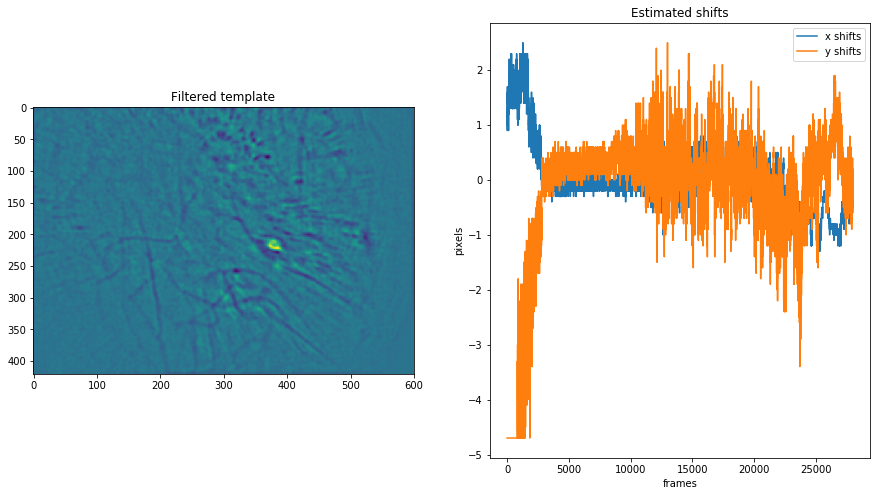

In [7]:
%matplotlib inline
if do_motion_correction_nonrigid or do_motion_correction_rigid:
    # do motion correction rigid
    mc = motion_correct_oneP_rigid(fnames,
                                   gSig_filt=gSig_filt,
                                   max_shifts=max_shifts,
                                   dview=dview,
                                   splits_rig=splits_rig,
                                   save_movie=not(do_motion_correction_nonrigid)
                                   )

    new_templ = mc.total_template_rig
    plt.figure(figsize=(15,8))
    plt.subplot(1,2,1)    
    plt.title('Filtered template')
    plt.imshow(new_templ)       #% plot template
    plt.subplot(1,2,2)
    plt.title('Estimated shifts')
    plt.plot(mc.shifts_rig)     #% plot rigid shifts
    plt.legend(['x shifts', 'y shifts'])
    plt.xlabel('frames')
    plt.ylabel('pixels')
    
    bord_px = np.ceil(np.max(np.abs(mc.shifts_rig))).astype(np.int)     #borders to eliminate from movie because of motion correction        

    # do motion correction nonrigid
    if do_motion_correction_nonrigid:
        mc = motion_correct_oneP_nonrigid(
            fnames,
            gSig_filt=gSig_filt,
            max_shifts=max_shifts,
            strides=strides,
            overlaps=overlaps,
            splits_els=splits_els,
            upsample_factor_grid=upsample_factor_grid,
            max_deviation_rigid=max_deviation_rigid,
            dview=dview,
            splits_rig=None,
            save_movie=True,  # whether to save movie in memory mapped format
            new_templ=new_templ  # template to initialize motion correction
        )

        bord_px = np.ceil(
            np.maximum(np.max(np.abs(mc.x_shifts_els)),
                       np.max(np.abs(mc.y_shifts_els)))).astype(np.int)

    # create memory mappable file in the right order on the hard drive (C order)        
        fname_new = cm.save_memmap([mc.fname_tot_els], base_name='memmap_',
                                   order = 'C', border_to_0=bord_px, dview=dview)
    else:
        fname_new = cm.save_memmap([mc.fname_tot_rig], base_name='memmap_',
                                   order = 'C', border_to_0=bord_px, dview=dview)
else:
    fname_new = cm.save_memmap(fnames, base_name='memmap_', order = 'C')

# load memory mappable file
Yr, dims, T = cm.load_memmap(fname_new)
Y = Yr.T.reshape((T,) + dims, order='F')

In [8]:
#load memory mappable file
Yr, dims, T = cm.load_memmap(fname_new)
Y = Yr.T.reshape((T,) + dims, order='F')

Play the movie (optional). This will require loading the movie in memory which in general is not needed by the pipeline. Displaying the movie uses the OpenCV library. Press `q` to close the video panel. **BEWARE** the movie may appear in the background!

In [9]:
# m_orig = cm.movie(Y)
# downsample_ratio = 5
# offset_mov = -np.min(m_orig[:100])  # make the dataset mostly non-negative
# print(m_orig.shape)
# m_orig[::downsample_ratio,:,:].crop_gui(gain=3.5, offset=offset_mov, fr=30, magnification=1)#,plot_text=True)

### Inspect summary images and set parameters
Check the optimal values of min_corr and min_pnr by moving slider in the figure that pops up

In [10]:
# # compute some summary images (correlation and peak to noise)
# cn_filter, pnr = cm.summary_images.correlation_pnr(Y, gSig=gSig, swap_dim=False) # change swap dim if output looks weird, it is a problem with tiffile
# # inspect the summary images and set the parameters
# inspect_correlation_pnr(cn_filter, pnr)

In [11]:
# print parameters set above, modify them if necessary based on summary images
# print(min_corr) # min correlation of peak (from correlation image)
# print(min_pnr)  # min peak to noise ratio

In [12]:
fname_new

'memmap__d1_420_d2_600_d3_1_order_C_frames_28000_.mmap'

### Set CNMF parameters and run it

In [48]:
# parameters for source extraction and deconvolution
p = 2               # order of the autoregressive system
K = None            # upper bound on number of components per patch, in general None
gSig = 3            # gaussian width of a 2D gaussian kernel, which approximates a neuron
gSiz = 4*gSig+1     # average diameter of a neuron, in general 4*gSig+1
merge_thresh = .2   # merging threshold, max correlation allowed
rf = 32             # half-size of the patches in pixels. e.g., if rf=40, patches are 80x80
stride_cnmf = 16    # amount of overlap between the patches in pixels
#                     (keep it at least large as gSiz, i.e 4 times the neuron size gSig)
tsub = 2            # downsampling factor in time for initialization,
#                     increase if you have memory problems
ssub = 1            # downsampling factor in space for initialization,
#                     increase if you have memory problems
Ain = None          # if you want to initialize with some preselected components
#                     you can pass them here as boolean vectors
low_rank_background = None  # None leaves background of each patch intact,
#                             True performs global low-rank approximation 
gnb = -2            # number of background components (rank) if positive,
#                     else exact ring model with following settings
#                         gnb=-2: Return background as b and W
#                         gnb=-1: Return full rank background B
#                         gnb= 0: Don't return background
nb_patch = -1       # number of background components (rank) per patch,
#                     use 0 or -1 for exact background of ring model (cf. gnb)
min_corr = .5       # min peak value from correlation image
min_pnr = 6        # min peak to noise ration from PNR image
ssub_B = 2          # additional downsampling factor in space for background
ring_size_factor = 1.5  # radius of ring is gSiz*ring_size_factor

In [49]:
cnm = cnmf.CNMF(n_processes=n_processes,
                method_init='corr_pnr',             # use this for 1 photon
                k=K,
                gSig=(gSig, gSig),
                gSiz=(gSiz, gSiz),
                merge_thresh=merge_thresh,
                p=p,
                dview=dview,
                tsub=tsub,
                ssub=ssub,
                Ain=Ain,
                rf=rf,
                stride=stride_cnmf,
                only_init_patch=True,               # just leave it as is
                gnb=gnb,
                nb_patch=nb_patch,
                method_deconvolution='oasis',       # could use 'cvxpy' alternatively
                low_rank_background=low_rank_background,
                update_background_components=True,  # sometimes setting to False improve the results
                min_corr=min_corr,
                min_pnr=min_pnr,
                normalize_init=False,               # just leave as is
                center_psf=True,                    # leave as is for 1 photon
                ssub_B=ssub_B,
                ring_size_factor=ring_size_factor,
                del_duplicates=True,                # whether to remove duplicates from initialization
                border_pix=bord_px)                 # number of pixels to not consider in the borders
cnm.fit(Y)

(28000, 420, 600)
using 16 processes
using 4000 pixels per process
using 5000 block_size
(64, 64)


MaybeEncodingError: Error sending result: '[[array([42521, 42522, 42523, ..., 69463, 69464, 69465]), (65, 65), <4225x2 sparse matrix of type '<class 'numpy.float32'>'
	with 551 stored elements in COOrdinate format>, array([[ 0.01394131,  0.01397018,  0.01396458, ...,  0.01399204,
         0.01396665,  0.01393962],
       [ 0.01397448,  0.01400339,  0.01399783, ...,  0.01403225,
         0.01400682,  0.01397973],
       [ 0.01395332,  0.01400721,  0.01395171, ...,  0.01401188,
         0.01404421,  0.01404144],
       ..., 
       [ 0.0166024 ,  0.01662103,  0.01662302, ...,  0.01644746,
         0.01643274,  0.01644703],
       [ 0.01661236,  0.016631  ,  0.016633  , ...,  0.01645953,
         0.0164448 ,  0.01645906],
       [ 0.01664317,  0.01662323,  0.01658759, ...,  0.01638851,
         0.01640371,  0.01647276]], dtype=float32), array([[-21.6995015 , -21.6995015 , -21.6995015 , ...,  13.36743152,
         12.7303031 ,  10.83644717],
       [-17.39553094, -17.39553094, -17.39553094, ...,   2.43201814,
          1.36232517,   0.35037627]]), array([[ 35787.08203125,      0.        ,      0.        , ...,
             0.        ,      0.        ,      0.        ],
       [     0.        ,  35743.18359375,      0.        , ...,
             0.        ,      0.        ,      0.        ],
       [     0.        ,      0.        ,  35703.10546875, ...,
             0.        ,      0.        ,      0.        ],
       ..., 
       [     0.        ,      0.        ,      0.        , ...,
         29524.4921875 ,      0.        ,      0.        ],
       [     0.        ,      0.        ,      0.        , ...,
             0.        ,  29556.25976562,      0.        ],
       [     0.        ,      0.        ,      0.        , ...,
             0.        ,      0.        ,  29601.68554688]], dtype=float32), array([[ 0.        ,  0.        ,  0.        , ...,  0.00107218,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]], dtype=float32), array([-0.0053718531418019272, -0.0085938997959059474], dtype=object), array([0.0, 0.0], dtype=object), array([7.3707356796389831, 6.8742964982229751], dtype=object), array([array([ 1.43058464, -0.47676827]), array([ 1.09285529, -0.13888355])], dtype=object), array([ 4.06404543,  4.19398546,  4.05688667, ...,  4.6252346 ,
        4.60193682,  4.81350565], dtype=float32), {'patch_params': {'ssub': 1, 'tsub': 1, 'only_init': True, 'skip_refinement': False, 'remove_very_bad_comps': False, 'nb': 1, 'in_memory': True}, 'preprocess_params': {'sn': None, 'noise_range': [0.25, 0.5], 'noise_method': 'mean', 'max_num_samples_fft': 3072, 'n_pixels_per_process': 1024, 'compute_g': False, 'p': 2, 'lags': 5, 'include_noise': False, 'pixels': None, 'check_nan': True}, 'init_params': {'K': None, 'gSig': (3, 3), 'gSiz': (13, 13), 'ssub': 1, 'tsub': 2, 'nIter': 5, 'kernel': None, 'maxIter': 5, 'method': 'corr_pnr', 'max_iter_snmf': 500, 'alpha_snmf': 1000.0, 'sigma_smooth_snmf': (0.5, 0.5, 0.5), 'perc_baseline_snmf': 20, 'nb': -1, 'normalize_init': False, 'options_local_NMF': None, 'rolling_sum': True, 'rolling_length': 100, 'min_corr': 0.5, 'min_pnr': 6, 'ring_size_factor': 1.5, 'center_psf': True, 'ssub_B': 2, 'init_iter': 2}, 'spatial_params': {'dims': (65, 65), 'method': 'dilate', 'dist': 3, 'n_pixels_per_process': 1024, 'medw': (3, 3), 'thr_method': 'nrg', 'maxthr': 0.1, 'nrgthr': 0.9999, 'extract_cc': True, 'se': array([[1]], dtype=uint8), 'ss': array([[1, 1, 1],
       [1, 1, 1],
       [1, 1, 1]], dtype=uint8), 'nb': -1, 'method_ls': 'lasso_lars', 'update_background_components': True, 'low_rank_background': True, 'block_size': 5000, 'num_blocks_per_run': 20}, 'temporal_params': {'ITER': 2, 'method': 'oasis', 'solvers': ['ECOS', 'SCS'], 'p': 2, 'memory_efficient': False, 'bas_nonneg': False, 'noise_range': [0.25, 0.5], 'noise_method': 'mean', 'lags': 5, 'fudge_factor': 0.96, 'nb': -1, 'verbosity': False, 'block_size': 5000, 's_min': None, 'num_blocks_per_run': 20}, 'merging': {'thr': 0.2}, 'quality': {'decay_time': 0.4, 'min_SNR': 2.5, 'SNR_lowest': 0.5, 'rval_thr': 0.8, 'rval_lowest': -1, 'fr': 30, 'use_cnn': True, 'min_cnn_thr': 0.9, 'cnn_lowest': 0.1, 'gSig_range': None}, 'online': {'expected_comps': 500, 'min_SNR': 2.5, 'N_samples_exceptionality': 12, 'thresh_fitness_raw': -60.979779327344289, 'rval_thr': 0.85, 'use_dense': True, 'max_num_added': 3, 'min_num_trial': 3, 'path_to_model': '/home/sebastian/caiman_data/model/cnn_model_online.h5', 'sniper_mode': True, 'use_peak_max': False, 'use_both': False, 'init_batch': 200, 'simultaneously': False, 'n_refit': 0, 'thresh_CNN_noisy': 0.5, 'epochs': 1, 'ds_factor': 1, 'motion_correct': True, 'max_shifts': 10, 'minibatch_shape': 100, 'update_num_comps': True, 's_min': None, 'init_method': 'bare'}}, array([[-30.7157917 , -30.26012039, -28.55860901, ...,   6.14011478,
         -5.91398907,  -2.45025563],
       [-24.67352867, -21.40189552, -26.24224854, ...,   7.31764889,
         10.70606709,  -8.53425694]], dtype=float32)], [array([62681, 62682, 62683, ..., 89623, 89624, 89625]), (65, 65), <4225x0 sparse matrix of type '<class 'numpy.float32'>'
	with 0 stored elements in COOrdinate format>, array([[ 0.01445192,  0.01445361,  0.01447978, ...,  0.01463676,
         0.01460572,  0.01459256],
       [ 0.01439516,  0.01439683,  0.01442297, ...,  0.01456796,
         0.014537  ,  0.01452392],
       [ 0.01442032,  0.01443056,  0.01446414, ...,  0.0144187 ,
         0.01449686,  0.01446413],
       ..., 
       [ 0.01627122,  0.01629861,  0.01633959, ...,  0.01628895,
         0.01630045,  0.01629933],
       [ 0.0163579 ,  0.01638532,  0.01642637, ...,  0.01639402,
         0.01640541,  0.01640416],
       [ 0.01636636,  0.01636055,  0.01634344, ...,  0.01640274,
         0.01638569,  0.01639204]], dtype=float32), array([], shape=(0, 28000), dtype=float32), array([[ 38190.81640625,      0.        ,      0.        , ...,
             0.        ,      0.        ,      0.        ],
       [     0.        ,  38177.40625   ,      0.        , ...,
             0.        ,      0.        ,      0.        ],
       [     0.        ,      0.        ,  38149.4140625 , ...,
             0.        ,      0.        ,      0.        ],
       ..., 
       [     0.        ,      0.        ,      0.        , ...,
         31507.3046875 ,      0.        ,      0.        ],
       [     0.        ,      0.        ,      0.        , ...,
             0.        ,  31541.765625  ,      0.        ],
       [     0.        ,      0.        ,      0.        , ...,
             0.        ,      0.        ,  31577.57226562]], dtype=float32), array([], shape=(0, 28000), dtype=float32), array([], dtype=object), array([], dtype=object), array([], dtype=object), array([], dtype=object), array([ 4.61622095,  4.53627253,  4.34205103, ...,  4.76586056,
        4.93590927,  4.92046881], dtype=float32), {'patch_params': {'ssub': 1, 'tsub': 1, 'only_init': True, 'skip_refinement': False, 'remove_very_bad_comps': False, 'nb': 1, 'in_memory': True}, 'preprocess_params': {'sn': None, 'noise_range': [0.25, 0.5], 'noise_method': 'mean', 'max_num_samples_fft': 3072, 'n_pixels_per_process': 1024, 'compute_g': False, 'p': 2, 'lags': 5, 'include_noise': False, 'pixels': None, 'check_nan': True}, 'init_params': {'K': None, 'gSig': (3, 3), 'gSiz': (13, 13), 'ssub': 1, 'tsub': 2, 'nIter': 5, 'kernel': None, 'maxIter': 5, 'method': 'corr_pnr', 'max_iter_snmf': 500, 'alpha_snmf': 1000.0, 'sigma_smooth_snmf': (0.5, 0.5, 0.5), 'perc_baseline_snmf': 20, 'nb': -1, 'normalize_init': False, 'options_local_NMF': None, 'rolling_sum': True, 'rolling_length': 100, 'min_corr': 0.5, 'min_pnr': 6, 'ring_size_factor': 1.5, 'center_psf': True, 'ssub_B': 2, 'init_iter': 2}, 'spatial_params': {'dims': (65, 65), 'method': 'dilate', 'dist': 3, 'n_pixels_per_process': 1024, 'medw': (3, 3), 'thr_method': 'nrg', 'maxthr': 0.1, 'nrgthr': 0.9999, 'extract_cc': True, 'se': array([[1]], dtype=uint8), 'ss': array([[1, 1, 1],
       [1, 1, 1],
       [1, 1, 1]], dtype=uint8), 'nb': -1, 'method_ls': 'lasso_lars', 'update_background_components': True, 'low_rank_background': True, 'block_size': 5000, 'num_blocks_per_run': 20}, 'temporal_params': {'ITER': 2, 'method': 'oasis', 'solvers': ['ECOS', 'SCS'], 'p': 2, 'memory_efficient': False, 'bas_nonneg': False, 'noise_range': [0.25, 0.5], 'noise_method': 'mean', 'lags': 5, 'fudge_factor': 0.96, 'nb': -1, 'verbosity': False, 'block_size': 5000, 's_min': None, 'num_blocks_per_run': 20}, 'merging': {'thr': 0.2}, 'quality': {'decay_time': 0.4, 'min_SNR': 2.5, 'SNR_lowest': 0.5, 'rval_thr': 0.8, 'rval_lowest': -1, 'fr': 30, 'use_cnn': True, 'min_cnn_thr': 0.9, 'cnn_lowest': 0.1, 'gSig_range': None}, 'online': {'expected_comps': 500, 'min_SNR': 2.5, 'N_samples_exceptionality': 12, 'thresh_fitness_raw': -60.979779327344289, 'rval_thr': 0.85, 'use_dense': True, 'max_num_added': 3, 'min_num_trial': 3, 'path_to_model': '/home/sebastian/caiman_data/model/cnn_model_online.h5', 'sniper_mode': True, 'use_peak_max': False, 'use_both': False, 'init_batch': 200, 'simultaneously': False, 'n_refit': 0, 'thresh_CNN_noisy': 0.5, 'epochs': 1, 'ds_factor': 1, 'motion_correct': True, 'max_shifts': 10, 'minibatch_shape': 100, 'update_num_comps': True, 's_min': None, 'init_method': 'bare'}}, array([], shape=(0, 28000), dtype=float32)]]'. Reason: 'error("'i' format requires -2147483648 <= number <= 2147483647",)'

In [ ]:
from caiman.utils.utils import save_object

cnm.dview=None

save_object(cnm, '/home/sebastian/Desktop/cnm.pkl')

In [ ]:
import matplotlib.pyplot as plt

spikes = cnm.S.copy()

# for i in range(spikes.shape[0]):
#     spikes[i,:]=spikes[i,:]/spikes[i,:].max()

# spikes[spikes.sum(1)>spikes.sum(1).mean(),:]=0
 
# plt.plot(spikes.sum(1)>spikes.sum(1).mean())
    
plt.imshow(spikes,aspect='auto')
#plt.yticks(range(21),range(1,22))

(2800, 420, 600)


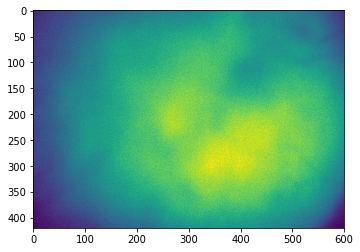

In [69]:
# y = np.zeros((1000000,))

# multi_step =[
#  [0.005, 10000],
#  [0.02, 430000],
#  [0.002, 730000],
#  [0.001, 1030000]]

# n = 0
# for step in multi_step:
#     print(step,n,step[1])
#     y[n:step[1]]=step[0]
#     n=step[1]
   

# d1=0.0001
# d2=0.01
# x1 = np.arange(y.shape[0])
# y1 = (x1*d1)*(0.9**(x1*d1))*d2 

# plt.plot(x1,y)
# plt.hold(True)
# plt.plot(x1,y1)

# try:
#     a = np.linalg.inv(np.zeros((3,3)))
# except:
#     a = np.linalg.lstsq(np.zeros((3,3)),[1,1,1])
#     print('tried...',a)


# m1 = cm.load('/home/sebastian/Desktop/32363_20170710_132114_trial.tif')
# print(m1.shape)


# plt.imshow(m1[1550,:,:]) 


plot contours of identified components against correlation image

In [ ]:
%matplotlib inline

from caiman.summary_images import correlation_pnr

cn_filter, pnr = correlation_pnr(Y, gSig=gSig, swap_dim=False)

plt.figure(figsize=(10,10))
crd = cm.utils.visualization.plot_contours(cnm.A, cn_filter, thr=.8, vmax=0.99)

In [ ]:
from caiman.base.traces import trace

plt.figure(figsize=(10,10))

trc = trace(cnm.S.T,fr = 10)
plt.title('Spikes:')
trc.plot()


## Component Evaluation

The processing in patches creates several spurious components. These are filtered out by evaluating each component using three different criteria:

- the shape of each component must be correlated with the data at the corresponding location within the FOV
- a minimum peak SNR is required over the length of a transient
- each shape passes a CNN based classifier

<img src="../../docs/img/evaluationcomponent.png"/>

In [ ]:
# parameters for component evaluation
min_SNR = 5            # adaptive way to set threshold on the transient size
r_values_min = 0.6    # threshold on space consistency (if you lower more components
#                        will be accepted, potentially with worst quality)

In [ ]:
#%% COMPONENT EVALUATION
# the components are evaluated in three ways:
#   a) the shape of each component must be correlated with the data
#   b) a minimum peak SNR is required over the length of a transient
#   c) each shape passes a CNN based classifier

idx_components, idx_components_bad, comp_SNR, r_values, pred_CNN = estimate_components_quality_auto(
                            Y, cnm.A, cnm.C, cnm.b, cnm.f, cnm.YrA, frate, 
                            decay_time, gSig, dims, dview=None, 
                            min_SNR=min_SNR, r_values_min=r_values_min, use_cnn=False)

print(' ***** ')
print((len(cnm.C)))
print((len(idx_components)))
print(r_values[idx_components_bad])

Plot contours of selected and rejected components

In [ ]:
#%% PLOT COMPONENTS

plt.figure(figsize=(15,8));
plt.subplot(121);
crd = cm.utils.visualization.plot_contours(cnm.A.tocsc()[:,idx_components], cn_filter, thr=.8, vmax=0.95)
plt.title('Contour plots of accepted components')
plt.subplot(122); 
crd = cm.utils.visualization.plot_contours(cnm.A.tocsc()[:,idx_components_bad], cn_filter, thr=.8, vmax=0.95)
plt.title('Contour plots of rejected components');

View traces of accepted and rejected components. Note that if you get data rate error you can start Jupyter notebooks using:
'jupyter notebook --NotebookApp.iopub_data_rate_limit=1.0e10'

In [ ]:
# accepted components
nb_view_patches(Yr, cnm.A.tocsc()[:, idx_components], cnm.C[idx_components], 
                cnm.b, cnm.f, dims[0], dims[1], YrA=cnm.YrA[idx_components], image_neurons=cn_filter,
                denoised_color='red', thr=0.8, cmap='gray');

In [ ]:
# rejected components
nb_view_patches(Yr, cnm.A.tocsc()[:, idx_components_bad], cnm.C[idx_components_bad], 
                cnm.b, cnm.f, dims[0], dims[1], YrA=cnm.YrA[idx_components_bad], image_neurons=cn_filter,
                denoised_color='red', thr=0.8, cmap='gray');

### Stop cluster

In [ ]:
cm.stop_server(dview=dview)

### Some instructive movies

In [ ]:
B = cnm.b.dot(cnm.f)
if 'sparse' in str(type(B)):
    B = B.toarray()

In [ ]:
#%% denoised movie
cm.movie(np.reshape(cnm.A.tocsc()[:,idx_components].dot(cnm.C[idx_components])+B,dims+(-1,), order = 'F').transpose(2,0,1)).play(magnification=1, gain = 1.)

In [ ]:
#%% only neurons
cm.movie(np.reshape(cnm.A.tocsc()[:,idx_components].dot(cnm.C[idx_components]),dims+(-1,), order = 'F').transpose(2,0,1)).play(magnification=1, gain = 10.)

In [ ]:
#%% only the background
cm.movie(np.reshape(B,dims+(-1,), order = 'F').transpose(2,0,1)).play(magnification=1, gain = 1.)

In [ ]:
#%% residuals
cm.movie(np.array(Y)-np.reshape(cnm.A.tocsc()[:,:].dot(cnm.C[:])+B,dims+(-1,), order = 'F').transpose(2,0,1)).play(magnification=1, gain = 1., fr = 10)


In [ ]:
#%% eventually, you can rerun the algorithm on the residuals
plt.imshow(cm.movie(np.array(Y)-np.reshape(cnm.A.tocsc()[:,:].dot(cnm.C[:])+B,dims+(-1,), order = 'F').transpose(2,0,1)).local_correlations(swap_dim=False))